In [3]:
import numpy as np
import matplotlib.pyplot as plt
#import h5py
import cv2
import os
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import IPython
from IPython.display import display
from PIL import Image
import matplotlib.image as mi
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.callbacks import Callback,ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#from keras_unet.models import custom_unet
#from keras_unet.models import vanilla_unet
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import backend as K
import keras
from IPython.display import FileLink
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
import pandas as pd
import random

In [4]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(tf.multiply(y_true_f, y_pred_f))
    score = (2. * intersection) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, [1, 2, 3])+K.sum(y_pred, [1, 2, 3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def recall(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    y_true_f = tf.round(y_true_f)
    y_pred_f = tf.round(y_pred_f)
    intersection = tf.reduce_sum(tf.multiply(y_true_f, y_pred_f))
    re = intersection/(tf.reduce_sum(y_true_f)+1)
    return re

def precision(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    y_true_f = tf.round(y_true_f)
    y_pred_f = tf.round(y_pred_f)
    intersection = tf.reduce_sum(tf.multiply(y_true_f, y_pred_f))
    pr = intersection/(tf.reduce_sum(y_pred_f)+1)
    return pr

In [5]:
def get_image(filename,model):
    img = cv2.imread(filename)
    i2 = cv2.imread(filename)
    image = cv2.imread(filename)
    image = cv2.resize(image,(128,128))
    image = image.reshape(128,128,3)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(128,128))
    img = img.reshape(128,128,1)
    min_val = img.min()
    max_val = img.max()
    img = (img - min_val) / (max_val - min_val)*255
    img2 = img[np.newaxis, :, :, :]
    print(img.shape)
    pmask = model.predict(img2)
    pmask = np.squeeze(pmask)
    pmask[pmask!=0] = 255
    #img[pmask != 255] = 0
    image[pmask==0] = (0,0,0)
    image = cv2.resize(image,(224,224))
    image = image.reshape(224,224,3)
    non_black_pixels = np.any(image != [0, 0, 0], axis=-1).nonzero()
    bbox = (
        np.min(non_black_pixels[1]),  # Left
        np.min(non_black_pixels[0]),  # Top
        np.max(non_black_pixels[1]),  # Right
        np.max(non_black_pixels[0]),  # Bottom
    )
    cropped_img = Image.fromarray(image).crop(bbox)
    cropped_img = np.array(cropped_img)
    cropped_img = cv2.resize(cropped_img,(224,224))
    cropped_img = cropped_img.reshape(224,224,3)
    return i2,pmask,image,cropped_img

<h4> Load the Model </h4> 

In [6]:
from keras.models import load_model
model = load_model(r'lung_mask_unet.h5', custom_objects={"dice_coeff": dice_coeff,"iou_coef": iou_coef,"recall": recall,"precision":precision })

<h3> Dataset 1 </h3>
<p> load all images from the folder, fit each image into the model to get the lung mask and segment the lung from each ctscan and load it into another folder </p>  

(128, 128, 1)
1/1 [==============================] - 0s 326ms/step


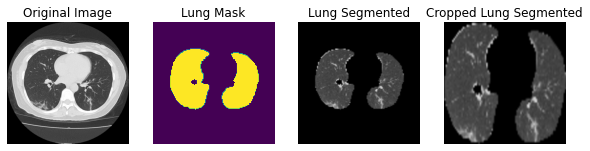

In [97]:
image,mask,seg,crop_seg = get_image(r"Dataset1\Orginal\pCT\pCT1.jpg",model)
ans = []
ans.append(image)
ans.append(mask)
ans.append(seg)
ans.append(crop_seg)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))
titles = ['Original Image', 'Lung Mask', 'Lung Segmented','Cropped Lung Segmented']
for i in range(4):
    ax[i].imshow(ans[i])
    ax[i].set_title(titles[i], fontsize=12)
    ax[i].axis('off')

# Show the plot
plt.show()

<h5> Load all the images from the folder </h5>

In [105]:
filesn = []
filesp = []
for i in os.listdir(r"Dataset1\Orginal\nCT"):
    filesn.append(i)
filesn = random.sample(filesn, 4001)
for i in os.listdir(r"Dataset1\Orginal\pCT"):
    filesp.append(i)
filesp = random.sample(filesp, 4001)

In [106]:
covid = []
non_covid = []
for i in filesn:
    name = r"Dataset1\Orginal\nCT\{img_name}".format(img_name=i)
    non_covid.append(name)
for i in filesp:
    name = r"Dataset1\Orginal\pCT\{img_name}".format(img_name=i)
    covid.append(name)

<h5> Get the segmented mask from the model and save the new images in a new folder</h5>

In [110]:
n_count = 1
p_count = 1
for filename in covid:
    image,mask,seg,crop_seg = get_image(filename,model)
    name1=r"Dataset1\Preprocessed\Covid\covid_img_{number}.png".format(number=str(p_count))
    p_count = p_count+1
    print(p_count)
    cv2.imwrite(name1,crop_seg)

for filename in non_covid:
    image,mask,seg,crop_seg = get_image(filename,model)
    name2=r"Dataset1\Preprocessed\Non-Covid\non-covid_img_{number}.png".format(number=str(n_count))
    n_count = n_count+1
    print(n_count)
    cv2.imwrite(name2,crop_seg)
    

(128, 128, 1)
1/1 [==============================] - 0s 323ms/step
2
(128, 128, 1)
1/1 [==============================] - 0s 476ms/step
3
(128, 128, 1)
1/1 [==============================] - 0s 362ms/step
4
(128, 128, 1)
1/1 [==============================] - 0s 314ms/step
5
(128, 128, 1)
1/1 [==============================] - 0s 329ms/step
6
(128, 128, 1)
1/1 [==============================] - 0s 341ms/step
7
(128, 128, 1)
1/1 [==============================] - 0s 334ms/step
8
(128, 128, 1)
1/1 [==============================] - 0s 300ms/step
9
(128, 128, 1)
1/1 [==============================] - 0s 306ms/step
10
(128, 128, 1)
1/1 [==============================] - 0s 320ms/step
11
(128, 128, 1)
1/1 [==============================] - 0s 301ms/step
12
(128, 128, 1)
1/1 [==============================] - 0s 290ms/step
13
(128, 128, 1)
1/1 [==============================] - 0s 305ms/step
14
(128, 128, 1)
1/1 [==============================] - 0s 274ms/step
15
(128, 128, 1)
1/1 [=========